### Overview
This notebooks reads a pre-processed set of **English questions** from Kenyan farmers, selects questions with **no topic**;   
tokenizes words, removes stopwords, & lemmatizes verbs; creates n-grams and network visualizations

### Inputs: (files are in your working directory)
* CSV files of cleaned / lower case /  punctuation removed questions: 'kenya_eng_q_clean.csv' 
* created by *question_preprocess.ipynb* --> *kenya-q_eng.ipynb* notebook code

### Output files (in working directory)
* CSV file of top 500 bigrams: 'ken_eng_bigrams_top500notopic.csv'
* CSV file of top 500 trigrams:  'ken_eng_trigrams_top500notopic.csv'
* PNG file of static network diagram of top 40 bigrams: 'top40bigrams_notopic_ken_eng_network.png'
* PNG file of static network diagram of top 30 trigrams:'top30trigrams_notopic_ken_eng_network.png'
* HTML file of interactive network diagram of top 40 bigrams: '40bigram_eng_ken_notopic_network.html'                                     
* HTML file of interactive network diagram of top 40 trigrams: '40trigram_eng_ken_notopic_network.html'
                                          
### Steps:
1. Select questions with no topic
2. Tokenize - takes ~ 3-4 min to run
3. Remove stopwords & lemmatise verbs
4. Create english bigrams, trigrams, & quadgrams; save as csv files
5. Plot frequency distribution of top 20 english bigrams, trigrams
6. Plot & save static network graphs of top 40 english bigrams and trigrams
7. Plot & save interactive networkgraphs of top 40 english bigrams and trigrams
                                                                                                                                                                       
### Local Variables (partial list):
* q_df       
* ken_q_list
* ken_eng_tokens
* all_bigrams
* all_trigrams
* bigram_freq
* unigram_freq                                          
* trigram_freq
                                          
                                                                                                                        

In [1]:
#import packages:  pandas, numpy,nltk, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import string
import re

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

#first - pyvis install in conda prompt: 'conda install conda-forge::pyvis'
from pyvis.network import Network

from collections import Counter

from IPython.display import HTML, display, IFrame


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#load processed country question file
q_df = pd.read_csv('kenya_eng_q_clean.csv')
q_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384774 entries, 0 to 1384773
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Unnamed: 0      1384774 non-null  int64 
 1   question_id     1384774 non-null  int64 
 2   question_topic  1083079 non-null  object
 3   question_clean  1384774 non-null  object
dtypes: int64(2), object(2)
memory usage: 42.3+ MB


In [3]:
#drop ~300,000 questions with topic = NaN:

clean_df=q_df.dropna(subset=['question_topic'])
len(clean_df)
eng_kenya_df = clean_df.loc[(clean_df['question_topic'] != ''),['question_clean']]
eng_kenya_df.head()


,question_clean
0,which plant has omega
1,what are the effects of animal waste on potato...
2,how much is price of kg of onions farmgate pr...
3,what is the iron of hens
4,what ìs the best sesion for planting pasion...


In [5]:
#create list of questions to be tokenized:
ken_q_list=list(eng_kenya_df['question_clean'])
print(ken_q_list[0:5])
print("The number of questions with no topic: ",len(ken_q_list))

['  which plant has omega ', 'what are the effects of animal waste on potato if aplied during planting ', ' how much is price of kg of onions farmgate price ', ' what is the iron of hens ', ' what ìs the  best sesion  for planting pasion fruit  ']
The number of questions with no topic:  1083079


In [4]:
# Define functions to tokenize list of questions:  


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def normalize_verbs(token_list):
    """Lemmatize verbs only."""
    return [lemmatizer.lemmatize(tok, wordnet.VERB) for tok in token_list]

def tokenize_stopwords_normalize(str_list):
    processed = []

    for text in str_list:
        # 1️⃣ tokenize
        tokens = word_tokenize(text)

        # 2️⃣ remove stopwords
        tokens = [
            t for t in tokens
            if t not in stop_words 
        ]

        # 3️⃣ normalize verbs
        tokens = normalize_verbs(tokens)

        processed.append(tokens)

    return processed

In [6]:
ken_eng_tokens = tokenize_stopwords_normalize(ken_q_list)
print(ken_eng_tokens[0:5])
print("Number of tokens: ", len(ken_eng_tokens))

[['plant', 'omega'], ['effect', 'animal', 'waste', 'potato', 'aplied', 'plant'], ['much', 'price', 'kg', 'onions', 'farmgate', 'price'], ['iron', 'hens'], ['ìs', 'best', 'sesion', 'plant', 'pasion', 'fruit']]
1083079


In [7]:
#create list of bigrams:
all_bigrams = []

for question in ken_eng_tokens:
    #create bigrams iterator for each element of tokens: ken_eng_tokens.csv
    bigram_iterator = bigrams(question)
    bigram_list = list(bigram_iterator)

    # Add the bigrams of the current question to the overall list
    all_bigrams.extend(bigram_list)

In [8]:
#create list of trigrams, if # tokens >= 3
all_trigrams = []

for question in ken_eng_tokens:
    if len(question) < 3:
        continue
            #create bigrams iterator for each element of tokens: 
    else:
        all_trigrams.extend(list(trigrams(question)))


In [9]:
print("# of trigrams: ", len(all_trigrams))
print(all_trigrams[0:5])
type(all_trigrams)

# of trigrams:  4319328
[('effect', 'animal', 'waste'), ('animal', 'waste', 'potato'), ('waste', 'potato', 'aplied'), ('potato', 'aplied', 'plant'), ('much', 'price', 'kg')]


list

In [10]:
print("# of bigrams: ", len(all_bigrams))
print(all_bigrams[0:5])
type(all_bigrams)

# of bigrams:  5399455
[('plant', 'omega'), ('effect', 'animal'), ('animal', 'waste'), ('waste', 'potato'), ('potato', 'aplied')]


list

In [11]:
bigram_freq = Counter(all_bigrams)
#type(bigram_freq)

In [12]:
trigram_freq = Counter(all_trigrams)
#type(trigram_freq)

### Bigram Visualizations:  Note - 2 most frequent bigrams aren't informative, so should be dropped

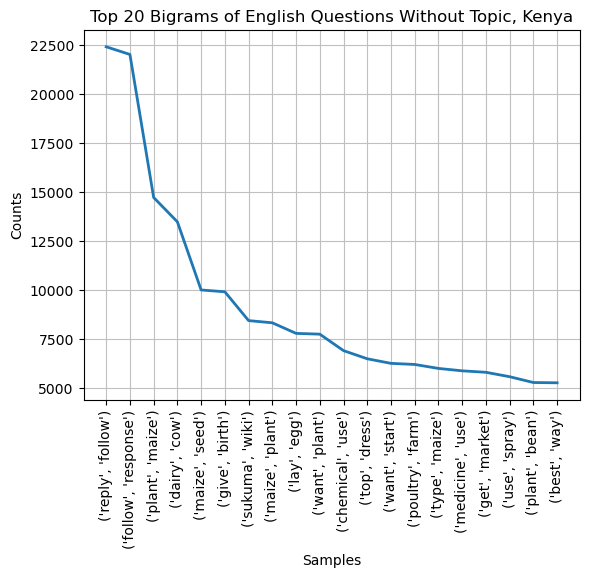

In [18]:
#plot frequency distribution of bigrams
fdist = FreqDist(all_bigrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} Bigrams of English Questions Without Topic, Kenya")
#plt.text(0.5, 1.02, "Source:  WeFarm SMS platform messages among farmers in East Africa, 2022" , fontsize=10, ha='center')
plt.savefig("top20bigrams_notopic_ken_eng.png")

In [13]:
#unigram counts for node-size based on token frequency:
 
unigram_freq = Counter(tok for tokens in ken_eng_tokens for tok in tokens)
print(unigram_freq.most_common(75))

[('plant', 165232), ('best', 130576), ('cow', 127609), ('maize', 122025), ('use', 83024), ('get', 66423), ('type', 64620), ('give', 56973), ('farm', 52869), ('many', 51062), ('ask', 47531), ('one', 47526), ('chicks', 45098), ('take', 44587), ('chicken', 44329), ('bean', 44190), ('good', 42925), ('tomatoes', 42521), ('seed', 41505), ('long', 38320), ('crop', 38255), ('want', 35867), ('grow', 35656), ('milk', 35156), ('control', 34541), ('start', 33805), ('potatoes', 32266), ('poultry', 30984), ('cause', 30820), ('dairy', 29578), ('problem', 28344), ('need', 28106), ('egg', 27699), ('cabbage', 27072), ('keep', 26451), ('time', 26122), ('county', 25901), ('follow', 25719), ('reply', 24991), ('breed', 24878), ('season', 24841), ('market', 24250), ('much', 23930), ('spray', 23450), ('rabbit', 22995), ('hen', 22785), ('response', 22356), ('variety', 22204), ('fee', 22190), ('medicine', 21583), ('know', 21469), ('make', 21078), ('hens', 20716), ('well', 20556), ('produce', 20361), ('disease',

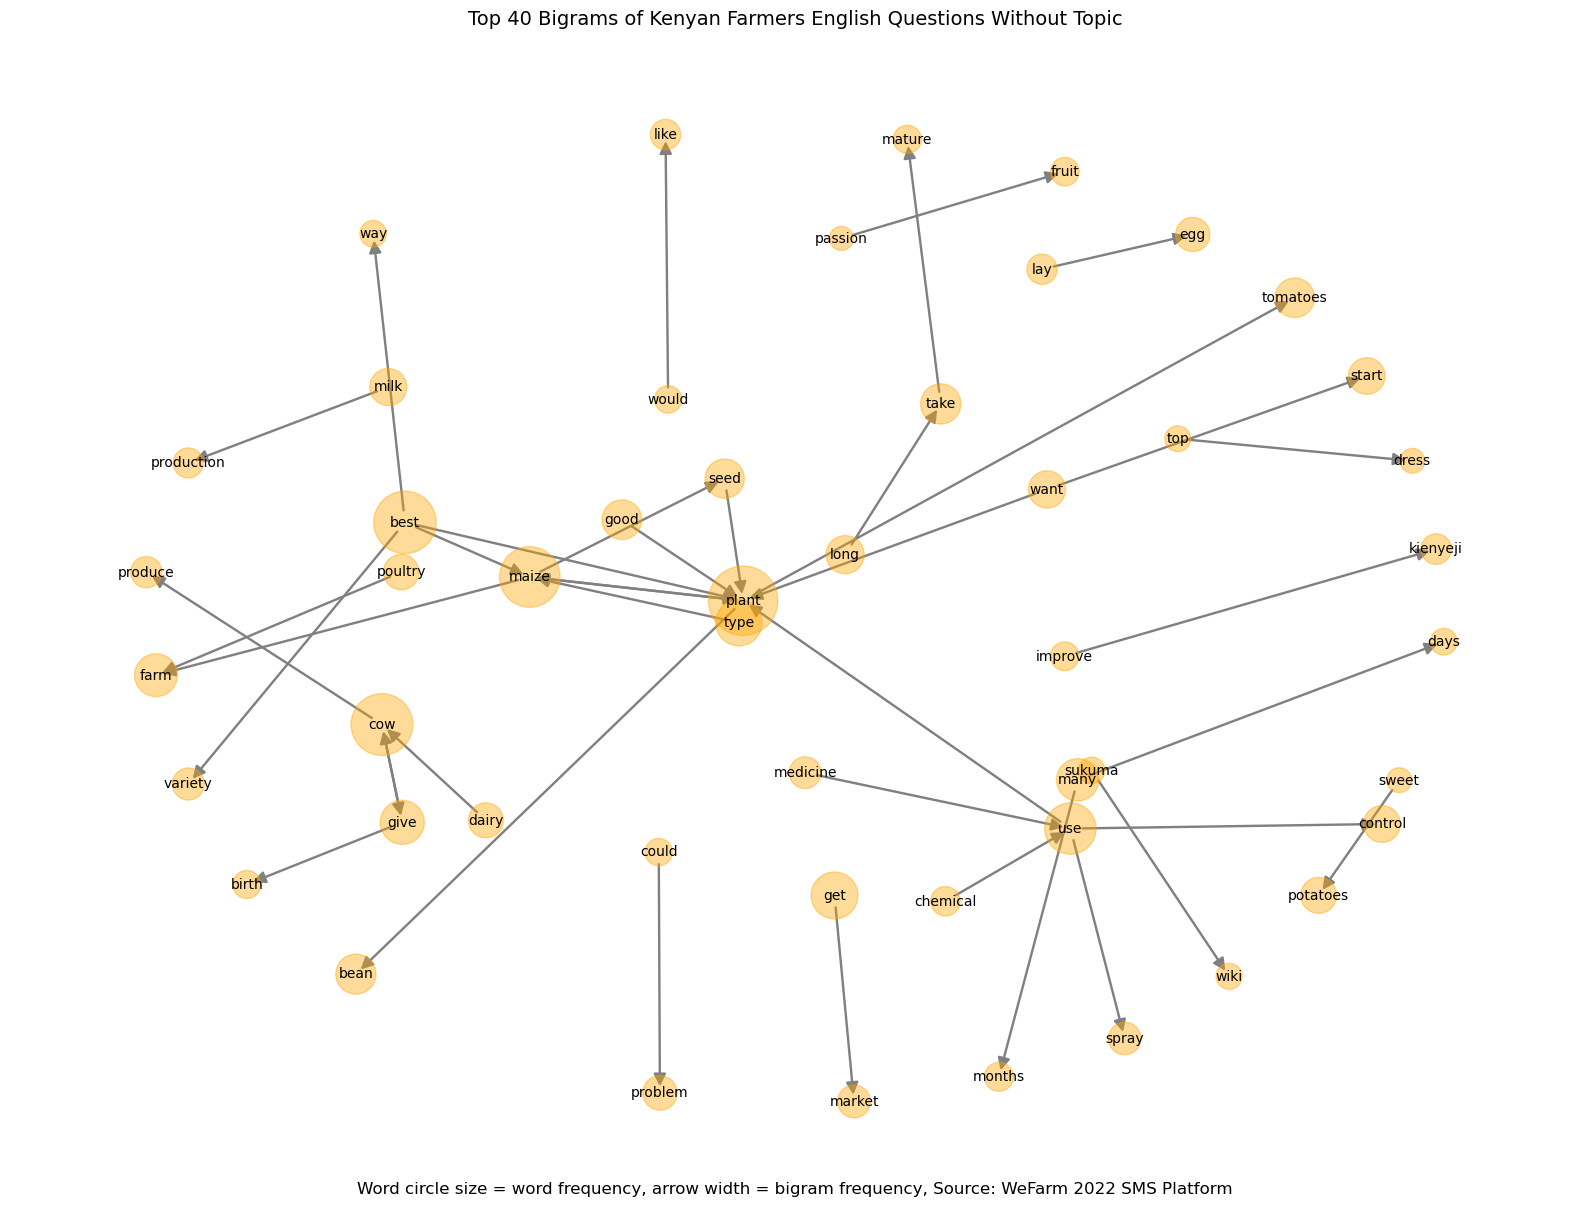

In [38]:
#create static directed network diagram of bi-grams counter from bigram_freq, with node size based on frequency


#choose most frequent N bigrams, after dropping first 2 bigrams:
top_n = 40
top_bigrams = bigram_freq.most_common()[2:top_n+2]


# ----------------------------------------------------------
# BUILD Directed network graph (with chatgpt's help)
# ----------------------------------------------------------
G = nx.DiGraph()

# Collect unique tokens appearing in the top 40 bigrams
unique_tokens = {w for (w1, w2), _ in top_bigrams for w in (w1, w2)}

# Extract unigram frequencies for scaling
freq_values = [unigram_freq[w] for w in unique_tokens]

min_node = min(freq_values)
max_node = max(freq_values)

# Desired matplotlib node-size range
min_size, max_size = 300, 2500

def scale_node_size(x):
    return min_size + (x - min_node) * (max_size - min_size) / (max_node - min_node)

# Add nodes
for token in unique_tokens:
    G.add_node(token, size=unigram_freq[token])

# Determine edge scaling from the actual top 40 frequencies
bigram_values = [freq for (_, freq) in top_bigrams]
min_edge = min(bigram_values)
max_edge = max(bigram_values)

min_w, max_w = 0.5, 6  # visual edge width range

def scale_edge_width(x):
    return min_w + (x - min_edge) * (max_w - min_w) / (max_edge - min_edge)

# Add edges, scale frequencies
for (w1, w2), freq in top_bigrams:
    G.add_edge(w1, w2, weight=freq/1000)
    
# Prepare lists for drawing
node_sizes = [scale_node_size(G.nodes[n]["size"]) for n in G.nodes]
edge_widths = [scale_edge_width(G[u][v]["weight"]) for u, v in G.edges]

# ----------------------------------------------------------
# PLOT
# ----------------------------------------------------------
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=6.0, seed=42,iterations=500)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="orange", alpha = 0.4)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color="gray",
                       arrows=True, arrowsize=18)
nx.draw_networkx_labels(G, pos, font_size=10)


# Bottom source label
plt.figtext(
    0.5, 0.02,
    "Word circle size = word frequency, arrow width = bigram frequency, Source: WeFarm 2022 SMS Platform",
    ha="center", fontsize=12
)


plt.tight_layout()
plt.title("Top 40 Bigrams of Kenyan Farmers English Questions Without Topic", fontsize=14)
plt.axis("off")
plt.savefig("top40bigrams_ken_eng_Notopic_network.png", dpi=300, bbox_inches="tight")
plt.show()

In [40]:
#create interactive directed network chart...with help from Anaconda toolbox

# Variables:
# - bigram_freq: Counter object with bigram frequencies (ranging from 5000 to 15000)
# - unigram_freq: Counter object with country unigram frequencies (ranging from 10000 to 150000)

# Get top 40 bigrams, excluding the first 2:
top_n = 40
top_bigrams2 = bigram_freq.most_common()[2:top_n+2]

# Create a graph
G = nx.DiGraph()

# Add edges (bigrams) with weights based on frequency
for bigram, frequency in top_bigrams2:
    word1, word2 = bigram
    G.add_edge(word1, word2, value=frequency, title=f"Frequency: {frequency}")

# Calculate node sizes based on unigram frequencies
max_node_size = 50  # Maximum node size for visualization
min_node_size = 10  # Minimum node size for visualization

# Get all unique words from the bigrams
all_words = set()
for bigram, _ in top_bigrams2:
    all_words.add(bigram[0])
    all_words.add(bigram[1])

# Set node sizes based on unigram frequencies
for word in all_words:
    # Get frequency from unigram counter, default to minimum if not found
    frequency = unigram_freq.get(word, 10000)
    
    # Scale node size based on frequency
    # Map from range [5000, 15000] to [min_node_size, max_node_size]
    size = min_node_size + (max_node_size - min_node_size) * (
        (frequency - 10000) / (150000 - 10000)
    ) if frequency >= 10000 else min_node_size
    
    # Set node attributes
    G.nodes[word]['size'] = size
    G.nodes[word]['title'] = f"{word}: {frequency}"
    G.nodes[word]['label'] = word

# Create interactive network
net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", font_color="black")
net.from_nx(G)

# Configure physics for better visualization
net.toggle_physics(True)
net.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=150)

# Add edge thickness based on bigram frequency

for edge in net.edges:
    # Scale edge width based on weight
   weight = edge['value']
    # Map from range [5000, 15000] to [1, 10] for edge width
   edge['width'] = 1 + 9 * ((weight - 5000) / (15000 - 5000)) if weight >= 5000 else 1
   edge['title'] = f"Frequency: {weight}"

    # Improve arrow visibility
   edge['arrows'] = 'to'
   edge['smooth'] = {'type': 'curvedCW', 'roundness': 0.2}  # Curved edges for better visibility
   edge['color'] = {'opacity': 0.5} 
    
# Add some color to distinguish nodes
subdued_colors = [
    '#7D9D9C', '#576F72', '#8B9A46', '#A4BE7B', '#5F7161', 
    '#6D8B74', '#94B49F', '#B4CFB0', '#9CB4CC', '#748DA6',
    '#6096B4', '#93BFCF', '#BDCDD6', '#9F73AB', '#A084DC'
]

for i, node in enumerate(net.nodes):
     node['font'] = {'bold': True, 'size': 16, 'face': 'arial'}
     node['color'] = subdued_colors[i % len(subdued_colors)]
     node['borderWidth'] = 2
     node['borderWidthSelected'] = 4


# Save the HTML file with the title and legend included
filename = "40bigram_eng_ken_notopic_network.html"
net.write_html(filename) 
print(f"Visualization saved as '{filename}'")

# Inject title + subtitle inside the iframe display
with open(filename, "r", encoding="utf-8") as f:
    html = f.read()

    header_html = f"""
    <div style="text-align:center; font-family:Arial; padding-top:10px;">
        <h1 style="margin-bottom:2px; font-size:20px;">Network Graph: Top 40 Bigrams from Kenyan Farmer English Questions (Without Topic)</h1>
        <h3 style="margin-top:0; color:#555; font-size:14px;">Word circle size = word frequency, arrow width = bigram frequency, Source: WeFarm 2022 SMS Platform</h3>
        <hr style="width:80%; margin-top:10px; margin-bottom:15px;">
    </div>
    """

# Insert heading right after <body>
html = html.replace("<body>", "<body>" + header_html)

with open(filename, "w", encoding="utf-8") as f:
    f.write(html)

# SIMPLE WAY TO ADD HEADER: Create a wrapper HTML with the visualization embedded
#header_html = f"""
#<div style="text-align:center; padding: 20px; font-family: Arial, sans-serif;">
#    <h1 style="color: #333; margin-bottom: 10px;">Top 40 Bigrams of English Questions Without Topic, Kenya"</h1>
#    <p style="color: #666; margin-bottom: 20px;">
#        Node size represents word frequency, Arrow thickness represents bigram frequency 
#    </p>
#</div>
#<iframe src="bigram_network.html" width="100%" height="800px" frameBorder="0"></iframe>
#"""

# Generate and display the interactive visualization, no title saved
#net.show("bigram_network.html")

# Display in notebook
display(IFrame(filename, width="100%", height="800px"))


Visualization saved as '40bigram_eng_ken_notopic_network.html'


### Trigram Visualizations:  Note - most frequent trigram isn't informative, so should be dropped

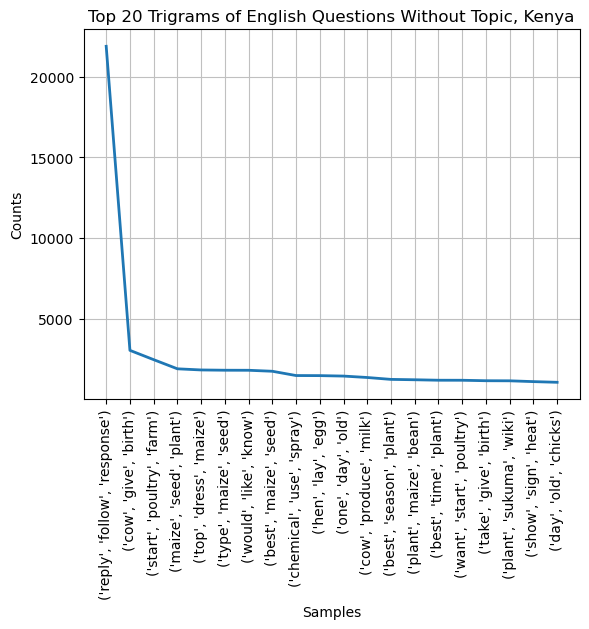

In [21]:
#plot frequency distribution of trigrams
fdist = FreqDist(all_trigrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} Trigrams of English Questions Without Topic, Kenya")
plt.savefig("top20trigrams_notopic_ken_eng.png")

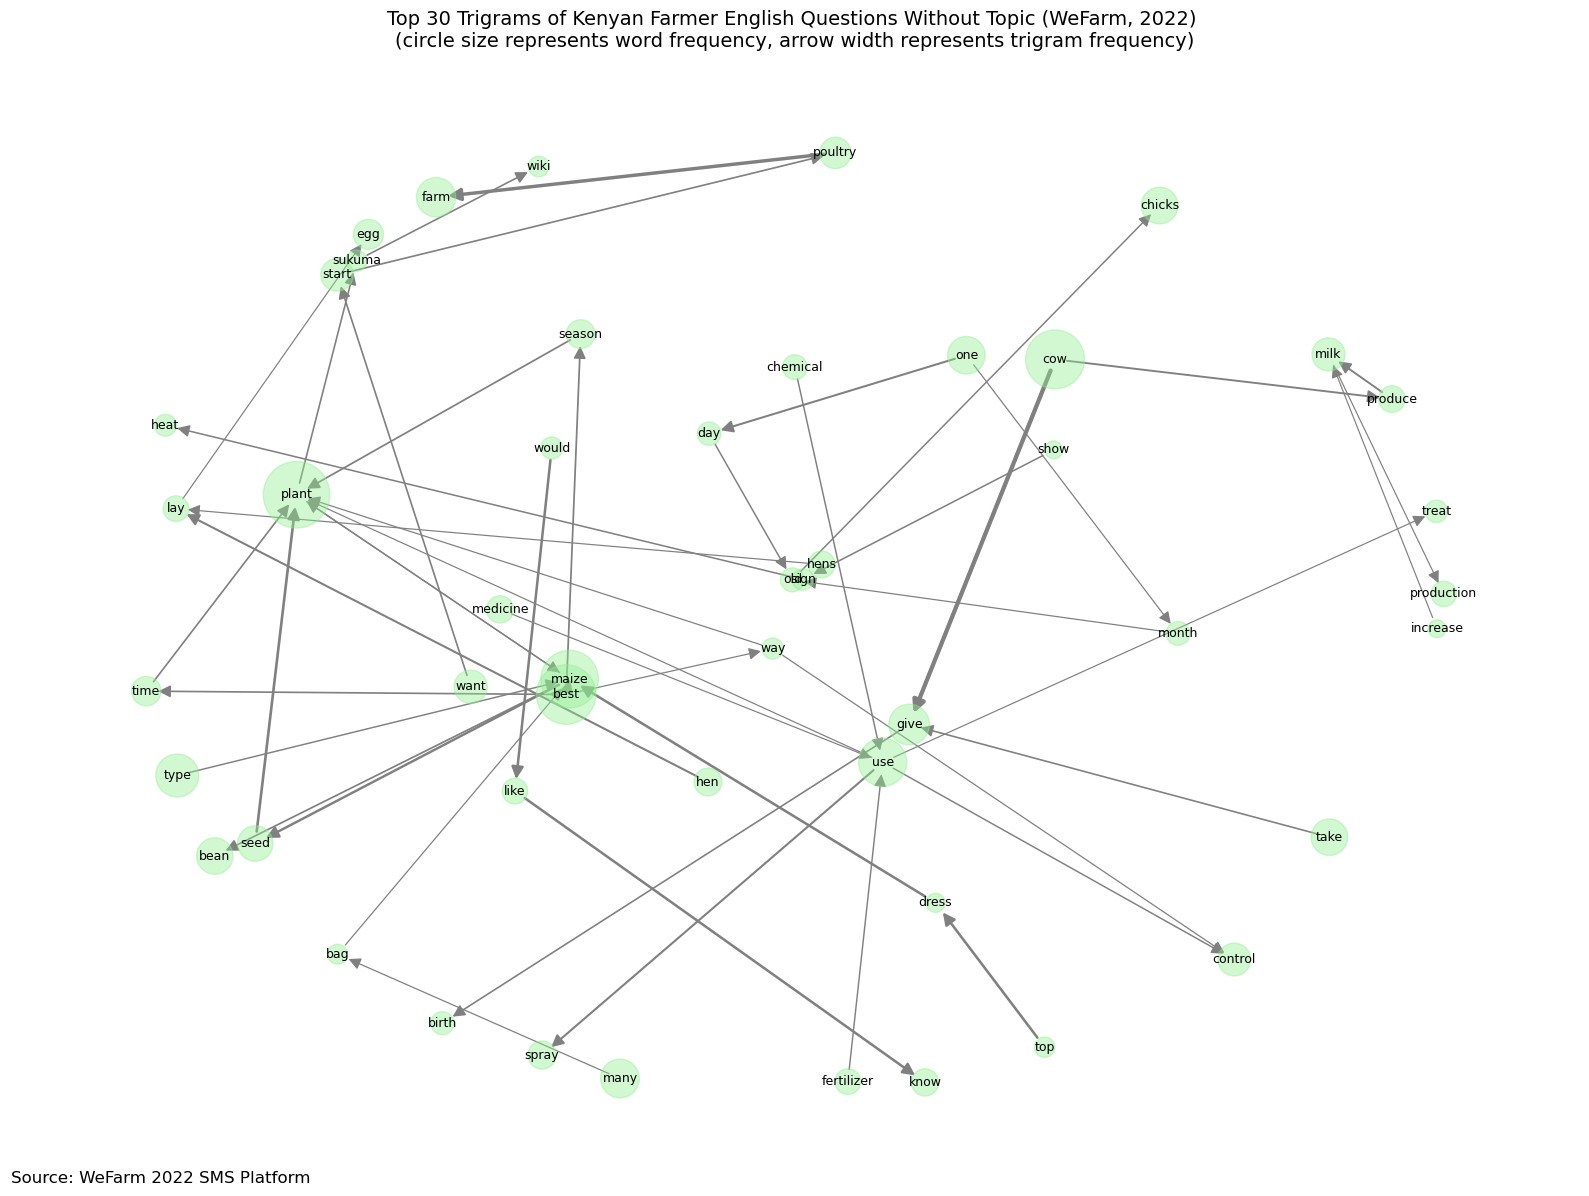

In [36]:
#create static network diagram of tri-grams counter from trigram_freq, with node size based on frequency

# Variables:
# - trigram_freq: Counter object with trigram frequencies ranging from 900 to 3000
# - unigram_freq: Counter object with country unigram frequencies up to 150000

#choose most frequent N bigrams, after dropping 1st trigram:
top_n = 30
top_trigrams = trigram_freq.most_common()[1:top_n+1]


# ----------------------------------------------------------
# BUILD GRAPH
# ----------------------------------------------------------
G = nx.DiGraph()

# Add nodes + node attributes (unigram frequencies)
for trigram, freq in top_trigrams:
    w1, w2, w3 = trigram
    
    # Ensure all nodes exist
    for w in (w1, w2, w3):
        if w not in G:
            G.add_node(w, size=unigram_freq[w])

# Add edges for trigram chain w1 → w2 and w2 → w3
for (w1, w2, w3), freq in top_trigrams:
    # Add or update edge weight
    G.add_edge(w1, w2, value=freq)
    G.add_edge(w2, w3, value=freq)

def scale_node_size(freq):
    return ((freq - 15000) / (150000 - 15000)) * 1800 + 300


# ----------------------------------------------------------
# EDGES: w1→w2 and w2→w3
# Edge width based on frequency / 1000
# ----------------------------------------------------------


for (w1, w2, w3), freq in top_trigrams:
    # first edge
    G.add_edge(w1, w2, weight=freq)
    # second edge
    G.add_edge(w2, w3, weight=freq)

node_sizes = [scale_node_size(G.nodes[n]["size"]) for n in G.nodes]
edge_widths = [G[u][v]["weight"] / 1000 for u, v in G.edges]

# ----------------------------------------------------------
# PLOT
# ----------------------------------------------------------
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=7.0, seed=42,iterations=600, weight = None)

#nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="orange", alpha = 0.4)
#nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color="gray",
#                      arrows=True, arrowsize=18)
nx.draw_networkx_labels(G, pos, font_size=9)



nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="lightgreen", alpha = 0.4)

nx.draw_networkx_edges(
    G, pos,
    width=edge_widths,
    edge_color="gray",
    arrows=True,
    arrowsize=18,
    #min_source_margin=5,
    #min_target_margin=5
)


plt.title(
    "Top 30 Trigrams of Kenyan Farmer English Questions Without Topic (WeFarm, 2022) \n"
    "(circle size represents word frequency, arrow width represents trigram frequency)",
    fontsize=14
)

plt.figtext(
    0.01, 0.01,
    "Source: WeFarm 2022 SMS Platform",
    ha="left", fontsize=12
)
plt.axis("off")
plt.tight_layout()
plt.savefig("top30trigrams_ken_eng_Notopic_network.png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
from IPython.display import IFrame

In [41]:
#interactive directed network graph of top 30 trigrams...with help from Anaconda Assistant

# Input variables:
# - trigram_freq: Counter object with trigram frequencies (ranging from 900 to 3000)
# - unigram_freq: Counter object with unigram frequencies (ranging from 10000 to 150000)

#choose most frequent N bigrams, after dropping 1st trigram:
top_n = 40
top_trigrams = trigram_freq.most_common()[1:top_n+1]

# Create a directed graph
G = nx.DiGraph()

# For trigrams, we'll create a path: word1 -> word2 -> word3
for trigram, frequency in top_trigrams:
    word1, word2, word3 = trigram
    
    # Add edges with weights based on frequency
    G.add_edge(word1, word2, value=frequency, title=f"Part of trigram: {' '.join(trigram)}, Frequency: {frequency}")
    G.add_edge(word2, word3, value=frequency, title=f"Part of trigram: {' '.join(trigram)}, Frequency: {frequency}")

# Calculate node sizes based on unigram frequencies
max_node_size = 50  # Maximum node size for visualization
min_node_size = 10  # Minimum node size for visualization

# Get all unique words from the trigrams
all_words = set()
for trigram, _ in top_trigrams:
    all_words.update(trigram)

# Set node sizes based on unigram frequencies
for word in all_words:
    # Get frequency from unigram counter, default to minimum if not found
    frequency = unigram_freq.get(word, 10000)
    
    # Scale node size based on frequency
    # Map from range [5000, 15000] to [min_node_size, max_node_size]
    size = min_node_size + (max_node_size - min_node_size) * (
        (frequency - 10000) / (150000 - 10000)
    ) if frequency >= 10000 else min_node_size

    
    # Set node attributes
    G.nodes[word]['size'] = size
    G.nodes[word]['title'] = f"{word}: {frequency}"
    G.nodes[word]['label'] = word

# Create interactive network with directed edges
net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", font_color="#333333", directed=True)
net.heading = ""

net.from_nx(G)

# Configure physics for better visualization
net.toggle_physics(True)
net.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=150)

# Subtle color palette
subtle_colors = [
    '#E6E6FA', '#D8BFD8', '#DDA0DD', '#EE82EE', '#DA70D6',
    '#BA55D3', '#9370DB', '#8A2BE2', '#9400D3', '#9932CC',
    '#8B008B', '#800080', '#4B0082', '#6A5ACD', '#483D8B',
    '#7B68EE', '#0000FF', '#0000CD', '#00008B', '#000080'
]

# Add edge thickness based on trigram frequency and make arrows somewhat opaque
for edge in net.edges:
    freq = edge['value']
    # Map from range [900, 3000] to [1, 8] for edge width
    edge['width'] = 1 + 7 * ((freq - 900) / (3000 - 900)) if freq >= 900 else 1
    edge['title'] = f"Frequency: {freq}"
    
    # Somewhat opaque curved arrows
    edge['color'] = {'color': '#848484', 'opacity': 0.5}  # 50% opacity
    edge['arrows'] = {'to': {'enabled': True, 'scaleFactor': 0.6}}
    edge['smooth'] = {'type': 'curvedCW', 'roundness': 0.2}

# Enhance node appearance with bold labels and subtle colors
for i, node in enumerate(net.nodes):
    node['font'] = {'bold': True, 'size': 16, 'face': 'arial'}
    node['color'] = subtle_colors[i % len(subtle_colors)]
    node['borderWidth'] = 2
    node['borderWidthSelected'] = 4

# Save the HTML file with the title and legend included
filename = "40trigram_eng_ken_notopic_network.html"
net.write_html(filename) 
print(f"Visualization saved as '{filename}'")

# Inject title + subtitle inside the iframe display
with open(filename, "r", encoding="utf-8") as f:
    html = f.read()

    header_html = f"""
    <div style="text-align:center; font-family:Arial; padding-top:10px;">
        <h1 style="margin-bottom:2px; font-size:20px;">Network Graph: Top 40 Trigrams from Kenyan Farmer English Questions (Without Topic)</h1>
        <h3 style="margin-top:0; color:#555; font-size:14px;">Word circle size = word frequency, arrow width = trigram frequency, Source: WeFarm 2022 SMS Platform</h3>
        <hr style="width:80%; margin-top:10px; margin-bottom:15px;">
    </div>
    """

# Insert heading right after <body>
html = html.replace("<body>", "<body>" + header_html)

with open(filename, "w", encoding="utf-8") as f:
    f.write(html)

#display in notebook:
display(IFrame(filename, width="100%", height="800px"))


Visualization saved as '40trigram_eng_ken_notopic_network.html'


### Save top 500 bigrams, trigrams to CSV files; plot top 40 quadgrams -- not that informative

In [26]:
#find top 500 bigrams:
top_500 = bigram_freq.most_common(500)
#convert top_500 list to df, and join bigrams with '_' as separators for later translation, note: there are no duplicates
ken_bigrams_500_df = pd.DataFrame(top_500, columns=['bigram','count'])
ken_bigrams_500_df["bigram_str"] = ken_bigrams_500_df["bigram"].apply(lambda t: "_".join(t))

In [27]:
#convert top_500 list to df, and join bigrams with '_' as separators for later translation, note: there are no duplicates
ken_bigrams_500_df = pd.DataFrame(top_500, columns=['bigram','count'])
ken_bigrams_500_df["bigram_str"] = ken_bigrams_500_df["bigram"].apply(lambda t: "_".join(t))
ken_bigrams_500_df.head()

,bigram,count,bigram_str
0,"(reply, follow)",22427,reply_follow
1,"(follow, response)",22036,follow_response
2,"(plant, maize)",14734,plant_maize
3,"(dairy, cow)",13490,dairy_cow
4,"(maize, seed)",10013,maize_seed


In [28]:
#save in csv file:
ken_bigrams_500_df.to_csv('ken_eng_bigrams_notopic_top500.csv')


In [52]:
#find top 500 trigrams:
top_500 = trigram_freq.most_common(500)
#convert top_500 list to df, and join trigrams with '_' as separators for later translation, note: there are no duplicates
ken_trigrams_500_df = pd.DataFrame(top_500, columns=['trigram','count'])
ken_trigrams_500_df["trigram_str"] = ken_trigrams_500_df["trigram"].apply(lambda t: "_".join(t))
ken_trigrams_500_df.head()

,trigram,count,trigram_str
0,"(reply, follow, response)",21874,reply_follow_response
1,"(cow, give, birth)",3055,cow_give_birth
2,"(start, poultry, farm)",2479,start_poultry_farm
3,"(maize, seed, plant)",1913,maize_seed_plant
4,"(top, dress, maize)",1842,top_dress_maize


In [53]:
#save in csv file:
ken_trigrams_500_df.to_csv('ken_eng_trigrams_notopic_top500.csv')


In [31]:
#create list of quadgrams, after checking # tokens >= 4
#from nltk.util import ngrams

all_quadgrams = []

for question in ken_eng_tokens:
    if len(question) < 4:
        continue
            #create bigrams iterator for each element of tokens: 
    else:
        all_quadgrams.extend(list(ngrams(question,4)))
        


In [32]:
print("# of quadgrams: ", len(all_quadgrams))


# of quadgrams:  3280743


In [33]:
quadgram_freq = Counter(all_quadgrams)

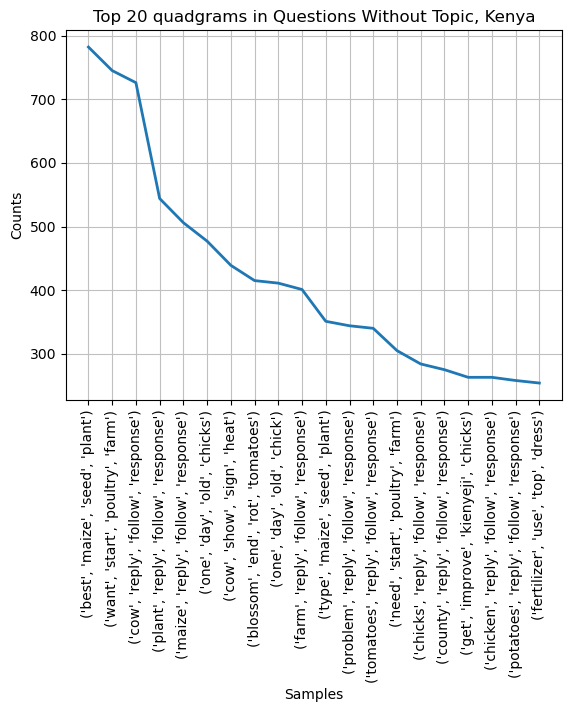

In [34]:
#top 20 quadgram plot

fdist = FreqDist(all_quadgrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} quadgrams in Questions Without Topic, Kenya")
plt.savefig("top20quadgrams_ken_notopic_eng.png")

In [35]:
#find top 500 quadgrams:
top_500 = quadgram_freq.most_common(500)
#convert top_500 list to df, and join quadgrams with '_' as separators for later translation, note: there are no duplicates
ken_quadgrams_500_df = pd.DataFrame(top_500, columns=['quadgram','count'])
ken_quadgrams_500_df["quadgram_str"] = ken_quadgrams_500_df["quadgram"].apply(lambda t: "_".join(t))

In [37]:
#save in csv file:
ken_quadgrams_500_df.to_csv('ken_eng_quadgrams_notopic_top500.csv')